In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mode, multimode

import json


In [2]:
%run 01_LLMs_konfigurieren.ipynb

In [3]:
%run 02_Daten_laden.ipynb

In [4]:
# Bilde ein Subset mit 1.000 Einträgen
sst2_subset = sst2_combined[:1000]
sst2_subset

,index,sentence,label
0,0,hide new secretions from the parental units,0
1,1,"contains no wit , only labored gags",0
2,2,that loves its characters and communicates som...,1
3,3,remains utterly satisfied to remain the same t...,0
4,4,on the worst revenge-of-the-nerds clichés the ...,0
...,...,...,...
995,995,you wish you were at home watching that movie ...,0
996,996,'s no point in extracting the bare bones of by...,0
997,997,underdeveloped,0
998,998,the jokes are flat,0


In [5]:
sb10k_subset = sb10k_combined[:1000]
sb10k_subset

,index,Text,Sentiment,sentiment_coded
0,0,RT @TheKedosZone : So ein Hearthstone - Key vo...,positive,1
1,1,"Tainted Talents ( Ateliertagebuch. ) "" Wir sin...",neutral,2
2,2,Aber wenigstens kommt #Supernatural heute mal ...,neutral,2
3,3,DARLEHEN - Angebot für Schufa - freie Darlehen...,neutral,2
4,4,ANRUF ERWÜNSCHT : Hardcore Teeny Vicky Carrera...,neutral,2
...,...,...,...,...
995,995,@sinkingFX Die Liebe unter Verwandten . : ' 3,positive,1
996,996,Cros Kindermusik braucht keiner .,negative,0
997,997,RT @ZDFsport : Extrem viele Braunschweiger hie...,positive,1
998,998,Moin Moin ... trotz Regen wünsche ich euch ein...,positive,1


# Chain of thought

## OpenAI / GPT

In [60]:
openai_client

### SST2

In [5]:
from pydantic import BaseModel

class Step(BaseModel):
    explanation: str
    output: str

class CoT(BaseModel):
    steps: list[Step]
    final_answer: str

In [6]:
# Bilde ein Subset mit 1.000 Einträgen
sst2_subset = sst2_combined[:1001]
sst2_subset

,index,sentence,label
0,0,hide new secretions from the parental units,0
1,1,"contains no wit , only labored gags",0
2,2,that loves its characters and communicates som...,1
3,3,remains utterly satisfied to remain the same t...,0
4,4,on the worst revenge-of-the-nerds clichés the ...,0
...,...,...,...
996,996,'s no point in extracting the bare bones of by...,0
997,997,underdeveloped,0
998,998,the jokes are flat,0
999,999,a heartening tale of small victories,1


In [7]:
# Leeres DataFrame erstellen, um die Ergebnisse zu speichern
results_gpt_df = pd.DataFrame(columns=['index', 'sentence','all_steps', 'all_labels', 'generated_label'])

# Zähler für das Einfügen in das DataFrame
row_counter = 0



# Zero-Shot
"""You classify sentiments of a text. Final_answer should be ONLY negative or positive!
Analyze the text step-by-step to determine whether it expresses positive or negative sentiment.
Explain each step in detail before providing your final answer."""

system_prompt = """You classify sentiments of a text. Final_answer should be ONLY negative or positive!
### EXAMPLES ###
Q: Classify the following text into one of these two sentiments ['negative', 'positive']. 
    Text: "The film’s mid-to-low budget is betrayed by the surprisingly shoddy makeup work."
A: The sentence “The film’s mid-to-low budget is betrayed by the surprisingly shoddy makeup work” can be classified as negative because several factors point to disappointment and deficiencies. 
    First, the film’s low to mid-range budget is mentioned, which might seem neutral or slightly negative at first. 
    However, the phrase “betrayed by” indicates an unexpected weakness, suggesting that a particular aspect highlights the film’s lower quality. 
    The term “surprisingly shoddy makeup work” is described as especially disappointing. The word “shoddy” means substandard or poorly done, and the fact that this is “surprisingly” bad suggests that better quality was expected. 
    This combination of unmet expectations and the emphasis on a negative aspect leads to an overall negative judgment.  """

user_prompt = ("""       
Classify the sentiment of the following text into one of these two sentiments ['negative', 'positive'].
""")

# Anzahl der Antworten, die vom Modell angefordert werden
n = 3 # um statistics error zu vermeiden

# Schleife mit API-Call
for index, row in sst2_subset.iterrows():
    text = row['sentence']

    answers = []
    all_steps = []
    #print(text)

    try:
        # GenAI Model-Aufruf für die Sentiment-Klassifikation
        response = openai_client.beta.chat.completions.parse( 
            model="gpt-4o-mini", # gpt-3.5-turbo # gpt-4o-mini
            messages=[
                { 
                "role": "system", 
                "content": system_prompt
                    
                },
                {
                "role": "user",
                 "content": (user_prompt + "Text:" + f"{text}")
                }
            ],
            temperature = 1,
            response_format=CoT,
            n = n
        )

        for i in range(n):
            response_content = response.choices[i].message.parsed 
            result_step = response_content.steps
            final_answer = response_content.final_answer
            
            # Speichern der finalen Antwort und Schritte
            answers.append(final_answer)
            all_steps.append(result_step)
            print(index, "n= ",i , "Label: ",final_answer )
        
        # Häufigste Antwort bestimmen
        if answers:
            consistent_answer = mode(answers)

            # Ergebnis in das DataFrame speichern, all_steps wird zu einer Zeichenkette konvertiert
            results_gpt_df.loc[row_counter] = [index, text, all_steps, answers, consistent_answer]
            row_counter += 1
            

    except Exception as e:
        # Fehlerbehandlung, wenn etwas beim API-Aufruf oder Speichern schiefgeht
        print(f"Fehler bei der Verarbeitung der Zeile {index}: {str(e)}")




0 n=  0 Label:  negative
0 n=  1 Label:  negative
0 n=  2 Label:  negative
1 n=  0 Label:  negative
1 n=  1 Label:  negative
1 n=  2 Label:  negative
2 n=  0 Label:  positive
2 n=  1 Label:  positive
2 n=  2 Label:  positive
3 n=  0 Label:  positive
3 n=  1 Label:  negative
3 n=  2 Label:  positive
4 n=  0 Label:  negative
4 n=  1 Label:  negative
4 n=  2 Label:  negative
5 n=  0 Label:  negative
5 n=  1 Label:  negative
5 n=  2 Label:  negative
6 n=  0 Label:  positive
6 n=  1 Label:  positive
6 n=  2 Label:  positive
7 n=  0 Label:  positive
7 n=  1 Label:  positive
7 n=  2 Label:  negative
8 n=  0 Label:  negative
8 n=  1 Label:  negative
8 n=  2 Label:  negative
9 n=  0 Label:  negative
9 n=  1 Label:  negative
9 n=  2 Label:  negative
10 n=  0 Label:  negative
10 n=  1 Label:  negative
10 n=  2 Label:  negative
11 n=  0 Label:  negative
11 n=  1 Label:  negative
11 n=  2 Label:  negative
12 n=  0 Label:  negative
12 n=  1 Label:  negative
12 n=  2 Label:  negative
13 n=  0 Label: 

In [10]:
# Datenaufbereitung 

# Entferne Zeilenumbrüche und Leerzeichen aus der Spalte 'generated_label'
results_gpt_df['generated_label'] = results_gpt_df['generated_label'].str.strip()

# Wandelt die Werte in Kleinbuchstaben um
results_gpt_df['generated_label'] = results_gpt_df['generated_label'].str.lower()

# Mapping: 'negative' zu 0, 'positive' zu 1
results_gpt_df_final = results_gpt_df # [results_gpt_df['generated_label'].isin(['0', '1',0,1])]

results_gpt_df_final['generated_label'] = results_gpt_df_final['generated_label'].replace({'negative': 0, 'positive': 1})

# Filtert den DataFrame, um nur Zeilen zu behalten, bei denen der Wert in 'generated_label' 0 oder 1 ist
results_gpt_df_final_ver = results_gpt_df_final[results_gpt_df_final['generated_label'].isin([0, 1])]

# als int formatieren
results_gpt_df_final_ver['generated_label'] = results_gpt_df_final_ver['generated_label'].astype(int)




/var/folders/55/3zlyt0sn7qx6794vb6c7gs1h0000gn/T/ipykernel_5538/829187267.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_gpt_df_final_ver['generated_label'] = results_gpt_df_final_ver['generated_label'].astype(int)


In [11]:
results_gpt_df_final_ver#['generated_label'].unique()

,index,sentence,all_steps,all_labels,generated_label
0,0,hide new secretions from the parental units,"[[explanation=""The phrase 'hide new secretions...","[negative, negative, negative]",0
1,1,"contains no wit , only labored gags","[[explanation='The phrase ""contains no wit"" in...","[negative, negative, negative]",0
2,2,that loves its characters and communicates som...,[[explanation='The text describes a sentiment ...,"[positive, positive, positive]",1
3,3,remains utterly satisfied to remain the same t...,"[[explanation='The phrase ""remains utterly sat...","[positive, negative, positive]",1
4,4,on the worst revenge-of-the-nerds clichés the ...,"[[explanation='The phrase ""worst revenge-of-th...","[negative, negative, negative]",0
...,...,...,...,...,...
996,996,'s no point in extracting the bare bones of by...,[[explanation='The text expresses a negative s...,"[negative, negative, negative]",0
997,997,underdeveloped,"[[explanation='The term ""underdeveloped"" gener...","[negative, negative, negative]",0
998,998,the jokes are flat,"[[explanation=""The phrase 'the jokes are flat'...","[negative, negative, negative]",0
999,999,a heartening tale of small victories,"[[explanation=""The phrase 'a heartening tale o...","[positive, positive, positive]",1


In [12]:

# CSV abspeichern 
results_gpt_df_final_ver.to_csv('/Users/marvinschmitt/Library/CloudStorage/OneDrive-Persönlich/M.Sc. Data Science/17 Masterarbeit/Repo/Prod/CSVs/SC_SST2_SelfConsistency4_GPT.csv')


### Evaluation

In [13]:

# Annahme: Beide DataFrames haben eine Spalte 'index' als gemeinsamen Schlüssel
# results_gpt_df: enthält die von LLM generierten Sentiment-Labels
# sst2_subset: enthält die tatsächlichen (gold standard) Sentiment-Labels

# Beide DataFrames anhand der 'index'-Spalte mergen
df_combined = pd.merge(sst2_subset, results_gpt_df_final_ver, on='index')

# Die Spalten 'label' und 'generated_label' sollten die tatsächlichen und vorhergesagten Labels enthalten
true_labels = df_combined['label']  # Tatsächliche Labels (z.B. aus SST2)
predicted_labels = df_combined['generated_label']  # Vorhergesagte Labels (z.B. aus GPT)

# 1. Accuracy (Genauigkeit)
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.2f}')

# 2. Precision (Genauigkeit der positiven Klassifikation)
precision = precision_score(true_labels, predicted_labels, pos_label=1)
print(f'Precision: {precision:.2f}')

# 3. Recall (Empfindlichkeit, Trefferquote)
recall = recall_score(true_labels, predicted_labels, pos_label=1)
print(f'Recall: {recall:.2f}')

# 4. F1-Score (harmonisches Mittel von Precision und Recall)
f1 = f1_score(true_labels, predicted_labels, pos_label=1)
print(f'F1-Score: {f1:.2f}')

# 5. Confusion Matrix (Verwirrungsmatrix)
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=[0,1])
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.84
Precision: 0.99
Recall: 0.72
F1-Score: 0.83
Confusion Matrix:
[[455   3]
 [153 389]]


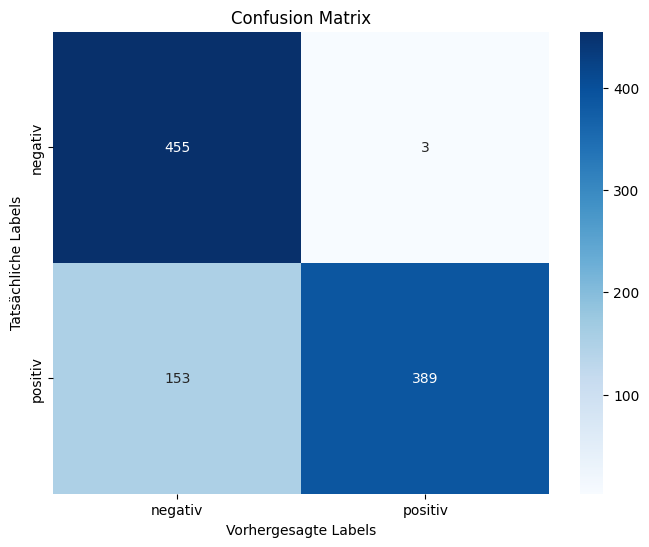

In [14]:
# Confusion Matrix berechnen (true_labels und predicted_labels sind die tatsächlichen und vorhergesagten Labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Klassenlabels definieren
class_names = ['negativ', 'positiv']

# Confusion Matrix als Heatmap darstellen
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Achsen beschriften
plt.xlabel('Vorhergesagte Labels')
plt.ylabel('Tatsächliche Labels')
plt.title('Confusion Matrix')

# Plot anzeigen
plt.show()

### SB10k

In [6]:
sb10k_subset

,index,Text,Sentiment,sentiment_coded
0,0,RT @TheKedosZone : So ein Hearthstone - Key vo...,positive,1
1,1,"Tainted Talents ( Ateliertagebuch. ) "" Wir sin...",neutral,2
2,2,Aber wenigstens kommt #Supernatural heute mal ...,neutral,2
3,3,DARLEHEN - Angebot für Schufa - freie Darlehen...,neutral,2
4,4,ANRUF ERWÜNSCHT : Hardcore Teeny Vicky Carrera...,neutral,2
...,...,...,...,...
995,995,@sinkingFX Die Liebe unter Verwandten . : ' 3,positive,1
996,996,Cros Kindermusik braucht keiner .,negative,0
997,997,RT @ZDFsport : Extrem viele Braunschweiger hie...,positive,1
998,998,Moin Moin ... trotz Regen wünsche ich euch ein...,positive,1


In [11]:
# Leeres DataFrame erstellen, um die Ergebnisse zu speichern
results_gpt_df = pd.DataFrame(columns=['index', 'sentence','all_steps', 'all_labels', 'generated_label'])

# Zähler für das Einfügen in das DataFrame
row_counter = 0

system_prompt = """Du klassifizierst die Sentiments eines Textes. Gib für final_answers NUR ['negativ', 'neutral', 'positiv'] zurück.
                    ### Beispiel ###
                    Eingabe: Klassifiziere den folgenden Text in einen von diesen drei Sentiments ['negativ', 'positiv', 'neutral']: 
                            Text: ‘@danieleicher PIN bitte per DM, welches Modell soll ich Dir kaufen?’
                    Ausgabe: Der Satz „@danieleicher PIN bitte per DM, welches Modell soll ich Dir kaufen?“ wird als neutral bewertet, 
                    da er keine emotionalen oder wertenden Elemente enthält. 
                    Zunächst handelt es sich um eine sachliche Anrede mit „@danieleicher“, die lediglich den Gesprächspartner adressiert. 
                    Die darauf folgende Bitte „PIN bitte per DM“ ist ebenfalls rein funktional formuliert, ohne positive oder negative Emotionen auszudrücken. 
                    Der zweite Teil des Satzes, „welches Modell soll ich Dir kaufen?“, ist eine einfache Frage, die nach einer Präferenz fragt, ohne eine Wertung oder Gefühlsregung zu implizieren. 
                    Insgesamt bleibt der Ton des Textes informativ und neutral, ohne erkennbare positive oder negative Konnotationen.
                    final_answer: neutral
                """

user_prompt = f"""Klassifiziere das Sentiment des folgenden Text in einen von diesen drei Sentiments ['negativ', 'neutral', 'positiv']"""

# Anzahl der Antworten, die vom Modell angefordert werden
n = 3

# Schleife mit API-Call
for index, row in sb10k_subset.iterrows():
    text = row['Text']

    answers = []
    all_steps = []
    #print(text)

    try:
        # GenAI Model-Aufruf für die Sentiment-Klassifikation
        response = openai_client.beta.chat.completions.parse( 
            model="gpt-4o-mini", # gpt-3.5-turbo # gpt-4o-mini
            messages=[
                { 
                "role": "system", 
                "content": system_prompt
                    
                },
                {
                "role": "user",
                 "content": (user_prompt + f"Text: {text}:")
                }
            ],
            temperature = 0.8,
            response_format=CoT,
            n = n
        )

        for i in range(n):
            response_content = response.choices[i].message.parsed 
            result_step = response_content.steps
            final_answer = response_content.final_answer
            
            # Speichern der finalen Antwort und Schritte
            answers.append(final_answer)
            all_steps.append(result_step)
            print(index, "n= ",i , "Label: ",final_answer )
        
        # Häufigste Antwort bestimmen
        if answers:
            consistent_answer = mode(answers)

            # Ergebnis in das DataFrame speichern, all_steps wird zu einer Zeichenkette konvertiert
            results_gpt_df.loc[row_counter] = [index, text, all_steps, answers, consistent_answer]
            row_counter += 1
            

    except Exception as e:
        # Fehlerbehandlung, wenn etwas beim API-Aufruf oder Speichern schiefgeht
        print(f"Fehler bei der Verarbeitung der Zeile {index}: {str(e)}")




0 n=  0 Label:  positiv
0 n=  1 Label:  positiv
0 n=  2 Label:  positiv
1 n=  0 Label:  neutral
1 n=  1 Label:  neutral
1 n=  2 Label:  neutral
2 n=  0 Label:  negativ
2 n=  1 Label:  negativ
2 n=  2 Label:  negativ
3 n=  0 Label:  neutral
3 n=  1 Label:  neutral
3 n=  2 Label:  neutral
4 n=  0 Label:  positiv
4 n=  1 Label:  positiv
4 n=  2 Label:  positiv
5 n=  0 Label:  neutral
5 n=  1 Label:  neutral
5 n=  2 Label:  neutral
6 n=  0 Label:  positiv
6 n=  1 Label:  positiv
6 n=  2 Label:  positiv
7 n=  0 Label:  negativ
7 n=  1 Label:  negativ
7 n=  2 Label:  negativ
8 n=  0 Label:  neutral
8 n=  1 Label:  neutral
8 n=  2 Label:  neutral
9 n=  0 Label:  positiv
9 n=  1 Label:  positiv
9 n=  2 Label:  positiv
10 n=  0 Label:  neutral
10 n=  1 Label:  neutral
10 n=  2 Label:  neutral
11 n=  0 Label:  neutral
11 n=  1 Label:  neutral
11 n=  2 Label:  neutral
12 n=  0 Label:  neutral
12 n=  1 Label:  neutral
12 n=  2 Label:  neutral
13 n=  0 Label:  positiv
13 n=  1 Label:  positiv
13 n=

In [13]:
results_gpt_df

,index,sentence,all_steps,all_labels,generated_label
0,0,RT @TheKedosZone : So ein Hearthstone - Key vo...,[[explanation='Der Text enthält eine Anrede un...,"[positiv, positiv, positiv]",positiv
1,1,"Tainted Talents ( Ateliertagebuch. ) "" Wir sin...","[[explanation='Der Satz ""Tainted Talents (Atel...","[neutral, neutral, neutral]",neutral
2,2,Aber wenigstens kommt #Supernatural heute mal ...,"[[explanation='Der Satz beginnt mit ""Aber weni...","[negativ, negativ, negativ]",negativ
3,3,DARLEHEN - Angebot für Schufa - freie Darlehen...,[[explanation='Der Text handelt von einem Ange...,"[neutral, neutral, neutral]",neutral
4,4,ANRUF ERWÜNSCHT : Hardcore Teeny Vicky Carrera...,"[[explanation='Der Text beginnt mit ""ANRUF ERW...","[positiv, positiv, positiv]",positiv
...,...,...,...,...,...
994,995,@sinkingFX Die Liebe unter Verwandten . : ' 3,"[[explanation=""Der Satz „@sinkingFX Die Liebe ...","[positiv, neutral, positiv]",positiv
995,996,Cros Kindermusik braucht keiner .,[[explanation='Der Satz „Cros Kindermusik brau...,"[negativ, negativ, negativ]",negativ
996,997,RT @ZDFsport : Extrem viele Braunschweiger hie...,[[explanation='Der Satz enthält eine positive ...,"[positiv, positiv, positiv]",positiv
997,998,Moin Moin ... trotz Regen wünsche ich euch ein...,"[[explanation='Der Satz beginnt mit ""Moin Moin...","[positiv, positiv, positiv]",positiv


In [14]:
# Entferne Zeilenumbrüche und Leerzeichen aus der Spalte 'generated_label'
results_gpt_df['generated_label'] = results_gpt_df['generated_label'].str.strip()

# Wandelt die Werte in Kleinbuchstaben um
results_gpt_df['generated_label'] = results_gpt_df['generated_label'].str.lower()

# Mapping: 'negative' zu 0, 'positive' zu 1
results_gpt_sb10k_df_ver = results_gpt_df # [results_gpt_sb10k_df['generated_label'].isin(['0', '1','2',0,1,2])]

# Mapping: 'negative', 'negativ' zu 0, 'positive', 'positiv' zu 1, 'neutral' zu 2
results_gpt_sb10k_df_ver['generated_label'] = results_gpt_sb10k_df_ver['generated_label'].replace({
    'negative': 0, 
    'negativ': 0, 
    'positive': 1, 
    'positiv': 1, 
    'neutral': 2
})

# Filtert den DataFrame, um nur Zeilen zu behalten, bei denen der Wert in 'generated_label' 0 oder 1 ist
results_gpt_sb10k_df_final = results_gpt_sb10k_df_ver[results_gpt_sb10k_df_ver['generated_label'].isin(['0', '1','2',0,1,2])]

# als int formatieren
results_gpt_sb10k_df_final['generated_label'] = results_gpt_sb10k_df_final['generated_label'].astype(int)


/var/folders/55/3zlyt0sn7qx6794vb6c7gs1h0000gn/T/ipykernel_95346/2419785378.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  results_gpt_sb10k_df_ver['generated_label'] = results_gpt_sb10k_df_ver['generated_label'].replace({


In [15]:
results_gpt_sb10k_df_final

,index,sentence,all_steps,all_labels,generated_label
0,0,RT @TheKedosZone : So ein Hearthstone - Key vo...,[[explanation='Der Text enthält eine Anrede un...,"[positiv, positiv, positiv]",1
1,1,"Tainted Talents ( Ateliertagebuch. ) "" Wir sin...","[[explanation='Der Satz ""Tainted Talents (Atel...","[neutral, neutral, neutral]",2
2,2,Aber wenigstens kommt #Supernatural heute mal ...,"[[explanation='Der Satz beginnt mit ""Aber weni...","[negativ, negativ, negativ]",0
3,3,DARLEHEN - Angebot für Schufa - freie Darlehen...,[[explanation='Der Text handelt von einem Ange...,"[neutral, neutral, neutral]",2
4,4,ANRUF ERWÜNSCHT : Hardcore Teeny Vicky Carrera...,"[[explanation='Der Text beginnt mit ""ANRUF ERW...","[positiv, positiv, positiv]",1
...,...,...,...,...,...
994,995,@sinkingFX Die Liebe unter Verwandten . : ' 3,"[[explanation=""Der Satz „@sinkingFX Die Liebe ...","[positiv, neutral, positiv]",1
995,996,Cros Kindermusik braucht keiner .,[[explanation='Der Satz „Cros Kindermusik brau...,"[negativ, negativ, negativ]",0
996,997,RT @ZDFsport : Extrem viele Braunschweiger hie...,[[explanation='Der Satz enthält eine positive ...,"[positiv, positiv, positiv]",1
997,998,Moin Moin ... trotz Regen wünsche ich euch ein...,"[[explanation='Der Satz beginnt mit ""Moin Moin...","[positiv, positiv, positiv]",1


In [16]:

# CSV abspeichern 
results_gpt_sb10k_df_final.to_csv('/Users/marvinschmitt/Library/CloudStorage/OneDrive-Persönlich/M.Sc. Data Science/17 Masterarbeit/Repo/Prod/CSVs/SC_SB10k_SelfConsistency2_GPT.csv', encoding='utf-8-sig')


#### Evaluation

In [17]:

# Beide DataFrames anhand der 'index'-Spalte mergen
df_combined = pd.merge(sb10k_subset, results_gpt_sb10k_df_final, on='index')

# Die Spalten 'label' und 'generated_label' sollten die tatsächlichen und vorhergesagten Labels enthalten
true_labels = df_combined['sentiment_coded']  # Tatsächliche Labels (z.B. aus SST2)
predicted_labels = df_combined['generated_label']  # Vorhergesagte Labels (z.B. aus GPT)

# 1. Accuracy (Genauigkeit)
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.2f}')

# 2. Precision (Genauigkeit der Klassifikation für alle Klassen)
precision = precision_score(true_labels, predicted_labels, average='macro')
print(f'Precision (macro): {precision:.2f}')

# 3. Recall (Empfindlichkeit für alle Klassen)
recall = recall_score(true_labels, predicted_labels, average='macro')
print(f'Recall (macro): {recall:.2f}')

# 4. F1-Score (harmonisches Mittel von Precision und Recall für alle Klassen)
f1 = f1_score(true_labels, predicted_labels, average='macro')
print(f'F1-Score (macro): {f1:.2f}')

# 5. Confusion Matrix (Verwirrungsmatrix)
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=[0, 1, 2])
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.63
Precision (macro): 0.63
Recall (macro): 0.72
F1-Score (macro): 0.63
Confusion Matrix:
[[144   5  12]
 [ 31 176  26]
 [167 126 312]]


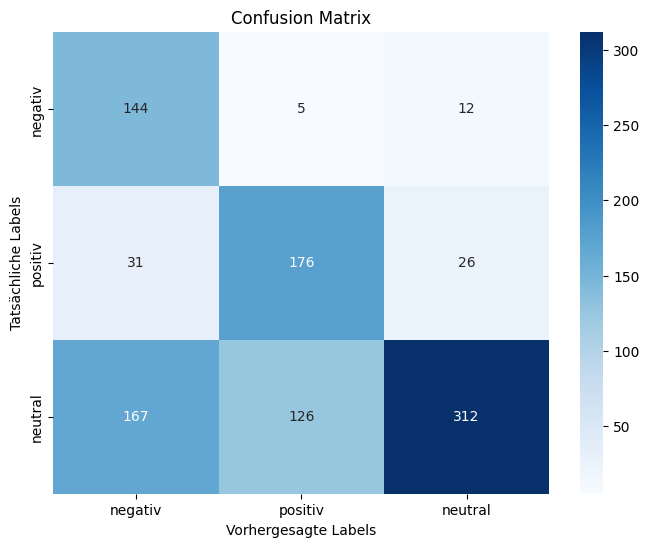

In [18]:
# Confusion Matrix berechnen (true_labels und predicted_labels sind die tatsächlichen und vorhergesagten Labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Klassenlabels definieren
class_names = ['negativ', 'positiv', 'neutral']

# Confusion Matrix als Heatmap darstellen
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Achsen beschriften
plt.xlabel('Vorhergesagte Labels')
plt.ylabel('Tatsächliche Labels')
plt.title('Confusion Matrix')

# Plot anzeigen
plt.show()

## Gemini

In [18]:
genai_model

genai.GenerativeModel(
    model_name='models/gemini-1.5-flash-001',
    generation_config={},
    safety_settings={},
    tools=None,
    system_instruction=None,
    cached_content=None
)

### SST2

In [133]:
# Bilde ein Subset mit 1.000 Einträgen
sst2_subset = sst2_combined[:1001]
sst2_subset

,index,sentence,label
0,0,hide new secretions from the parental units,0
1,1,"contains no wit , only labored gags",0
2,2,that loves its characters and communicates som...,1
3,3,remains utterly satisfied to remain the same t...,0
4,4,on the worst revenge-of-the-nerds clichés the ...,0
...,...,...,...
996,996,'s no point in extracting the bare bones of by...,0
997,997,underdeveloped,0
998,998,the jokes are flat,0
999,999,a heartening tale of small victories,1


In [142]:
# System-Prompts

genai_model=genai.GenerativeModel(
  model_name="gemini-1.5-flash",
    safety_settings='BLOCK_NONE',
    system_instruction="""
    You classify sentiments of a text. Think step-by-step and use this JSON Schema: Result = {'steps':str, 'final_answer': str}. Use ONLY 'negative' or 'positive' for final_answer!
    Example:
        Input: Classify the following text ONLY in one of these two sentiments ['negative', 'positive']. 
            Text: "The film’s mid-to-low budget is betrayed by the surprisingly shoddy makeup work."
        Answer: {'steps': "The sentence “The film’s mid-to-low budget is betrayed by the surprisingly shoddy makeup work” can be classified as negative because several factors point to disappointment and deficiencies. 
                First, the film’s low to mid-range budget is mentioned, which might seem neutral or slightly negative at first. 
                However, the phrase “betrayed by” indicates an unexpected weakness, suggesting that a particular aspect highlights the film’s lower quality. 
                The term “surprisingly shoddy makeup work” is described as especially disappointing. The word “shoddy” means substandard or poorly done, and the fact that this is “surprisingly” bad suggests that better quality was expected. 
                This combination of unmet expectations and the emphasis on a negative aspect leads to an overall negative judgment.", 
                'final_answer': Negative
                 """,
    generation_config={"response_mime_type": "application/json","temperature":1})

# Leeres DataFrame erstellen, um die Ergebnisse zu speichern
results_gemini_df = pd.DataFrame(columns=['index', 'sentence', 'all_steps', 'all_labels', 'generated_label'])

# Zähler für das Einfügen in das DataFrame
row_counter = 0

# Anzahl der Wiederholungen für Self-Consistency
num_samples = 3

# Schleife mit API-Call
for index, row in sst2_subset.iterrows():
    text = row['sentence']
    
    # Liste zum Speichern von Antworten und deren Details
    answers = []
    all_steps = []
    
    try:
        # Self-Consistency: Mehrere Antworten generieren
        for _ in range(num_samples):
            # GenAI Model-Aufruf für die Sentiment-Klassifikation
            response = genai_model.generate_content(f"""Classify the following text ONLY in one of these two sentiments 
                                                    ['negative', 'positive']. Text: {text}.""")
            llm_output = response.text
            
            # Antwort parsen und speichern
            resp_dict = json.loads(llm_output)
            steps = resp_dict['steps']
            final_result = resp_dict['final_answer']

            # In Liste hinzufügen
            answers.append(final_result)
            all_steps.append(steps)

            print("Index: ", index, "n= ",_ , "Label: ", final_result)

        
        # Mehrheit der final answers bestimmen (Voting-Mechanismus)
        try:
            most_common_answer = mode(answers)
        except StatisticsError:
            # Wenn mehrere Modi vorhanden sind, nimm den ersten Wert von multimode()
            most_common_answer = multimode(answers)[0]
            print(f"Mehrere häufigste Antworten für Index {index}, Auswahl: {most_common_answer}")


        # Ergebnis in das DataFrame speichern
        results_gemini_df.loc[row_counter] = [index, text, all_steps, answers, most_common_answer]
        row_counter += 1

    except Exception as e:
        # Fehlerbehandlung, wenn etwas beim API-Aufruf oder Speichern schiefgeht
        print(f"Fehler bei der Verarbeitung der Zeile {index}: {str(e)}")

Index:  0 n=  0 Label:  negative
Index:  0 n=  1 Label:  negative
Index:  0 n=  2 Label:  negative
Index:  1 n=  0 Label:  negative
Index:  1 n=  1 Label:  negative
Index:  1 n=  2 Label:  negative
Index:  2 n=  0 Label:  positive
Index:  2 n=  1 Label:  positive
Index:  2 n=  2 Label:  positive
Index:  3 n=  0 Label:  positive
Index:  3 n=  1 Label:  positive
Index:  3 n=  2 Label:  positive
Index:  4 n=  0 Label:  negative
Index:  4 n=  1 Label:  negative
Index:  4 n=  2 Label:  negative
Index:  5 n=  0 Label:  negative
Index:  5 n=  1 Label:  negative
Index:  5 n=  2 Label:  negative
Index:  6 n=  0 Label:  positive
Index:  6 n=  1 Label:  positive
Index:  6 n=  2 Label:  positive
Index:  7 n=  0 Label:  negative
Index:  7 n=  1 Label:  negative
Index:  7 n=  2 Label:  negative
Index:  8 n=  0 Label:  negative
Index:  8 n=  1 Label:  negative
Index:  8 n=  2 Label:  negative
Index:  9 n=  0 Label:  positive
Index:  9 n=  1 Label:  positive
Index:  9 n=  2 Label:  positive
Index:  10

In [143]:
results_gemini_df 

,index,sentence,all_steps,all_labels,generated_label
0,0,hide new secretions from the parental units,"[The phrase ""hide new secretions from the pare...","[negative, negative, negative]",negative
1,1,"contains no wit , only labored gags","[The phrase ""contains no wit, only labored gag...","[negative, negative, negative]",negative
2,2,that loves its characters and communicates som...,"[The sentence ""that loves its characters and c...","[positive, positive, positive]",positive
3,3,remains utterly satisfied to remain the same t...,"[The text ""remains utterly satisfied to remain...","[positive, positive, positive]",positive
4,4,on the worst revenge-of-the-nerds clichés the ...,[The phrase “on the worst revenge-of-the-nerds...,"[negative, negative, negative]",negative
...,...,...,...,...,...
985,996,'s no point in extracting the bare bones of by...,"[The statement ""There's no point in extracting...","[negative, negative, negative]",negative
986,997,underdeveloped,[The single word “underdeveloped” is inherentl...,"[negative, negative, negative]",negative
987,998,the jokes are flat,[The sentence “the jokes are flat” expresses a...,"[negative, negative, negative]",negative
988,999,a heartening tale of small victories,"[The phrase ""a heartening tale of small victor...","[positive, positive, positive]",positive


In [144]:
# Datenaufbereitung 

# Entferne Zeilenumbrüche und Leerzeichen aus der Spalte 'generated_label'
results_gemini_df['generated_label'] = results_gemini_df['generated_label'].str.strip()

# Wandelt die Werte in Kleinbuchstaben um
results_gemini_df['generated_label'] = results_gemini_df['generated_label'].str.lower()

# Mapping: 'negative' zu 0, 'positive' zu 1
results_gemini_df_final = results_gemini_df # [results_gpt_df['generated_label'].isin(['0', '1',0,1])]

results_gemini_df_final['generated_label'] = results_gemini_df_final['generated_label'].replace({'negative': 0, 'positive': 1})

# Filtert den DataFrame, um nur Zeilen zu behalten, bei denen der Wert in 'generated_label' 0 oder 1 ist
results_gemini_df_final_ver = results_gemini_df_final[results_gemini_df_final['generated_label'].isin([0, 1])]

# als int formatieren
results_gemini_df_final_ver['generated_label'] = results_gemini_df_final_ver['generated_label'].astype(int)




/var/folders/55/3zlyt0sn7qx6794vb6c7gs1h0000gn/T/ipykernel_52930/3204135013.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_gemini_df_final_ver['generated_label'] = results_gemini_df_final_ver['generated_label'].astype(int)


In [145]:
results_gemini_df_final_ver

,index,sentence,all_steps,all_labels,generated_label
0,0,hide new secretions from the parental units,"[The phrase ""hide new secretions from the pare...","[negative, negative, negative]",0
1,1,"contains no wit , only labored gags","[The phrase ""contains no wit, only labored gag...","[negative, negative, negative]",0
2,2,that loves its characters and communicates som...,"[The sentence ""that loves its characters and c...","[positive, positive, positive]",1
3,3,remains utterly satisfied to remain the same t...,"[The text ""remains utterly satisfied to remain...","[positive, positive, positive]",1
4,4,on the worst revenge-of-the-nerds clichés the ...,[The phrase “on the worst revenge-of-the-nerds...,"[negative, negative, negative]",0
...,...,...,...,...,...
985,996,'s no point in extracting the bare bones of by...,"[The statement ""There's no point in extracting...","[negative, negative, negative]",0
986,997,underdeveloped,[The single word “underdeveloped” is inherentl...,"[negative, negative, negative]",0
987,998,the jokes are flat,[The sentence “the jokes are flat” expresses a...,"[negative, negative, negative]",0
988,999,a heartening tale of small victories,"[The phrase ""a heartening tale of small victor...","[positive, positive, positive]",1


In [146]:

# CSV abspeichern 
results_gemini_df_final_ver.to_csv('/Users/marvinschmitt/Library/CloudStorage/OneDrive-Persönlich/M.Sc. Data Science/17 Masterarbeit/Repo/Prod/CSVs/SC_SST2_SelfConsistency2_GEMINI.csv', encoding='utf-8-sig')


#### Evaluation

In [147]:

# Annahme: Beide DataFrames haben eine Spalte 'index' als gemeinsamen Schlüssel
# results_gpt_df: enthält die von LLM generierten Sentiment-Labels
# sst2_subset: enthält die tatsächlichen (gold standard) Sentiment-Labels

# Beide DataFrames anhand der 'index'-Spalte mergen
df_combined = pd.merge(sst2_subset, results_gemini_df_final_ver, on='index')

# Die Spalten 'label' und 'generated_label' sollten die tatsächlichen und vorhergesagten Labels enthalten
true_labels = df_combined['label']  # Tatsächliche Labels (z.B. aus SST2)
predicted_labels = df_combined['generated_label']  # Vorhergesagte Labels (z.B. aus GPT)

# 1. Accuracy (Genauigkeit)
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.2f}')

# 2. Precision (Genauigkeit der positiven Klassifikation)
precision = precision_score(true_labels, predicted_labels, pos_label=1)
print(f'Precision: {precision:.2f}')

# 3. Recall (Empfindlichkeit, Trefferquote)
recall = recall_score(true_labels, predicted_labels, pos_label=1)
print(f'Recall: {recall:.2f}')

# 4. F1-Score (harmonisches Mittel von Precision und Recall)
f1 = f1_score(true_labels, predicted_labels, pos_label=1)
print(f'F1-Score: {f1:.2f}')

# 5. Confusion Matrix (Verwirrungsmatrix)
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=[0,1])
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.90
Precision: 0.97
Recall: 0.84
F1-Score: 0.90
Confusion Matrix:
[[435  15]
 [ 85 438]]


### SB10k

In [164]:
sb10k_subset

,index,Text,Sentiment,sentiment_coded
0,0,RT @TheKedosZone : So ein Hearthstone - Key vo...,positive,1
1,1,"Tainted Talents ( Ateliertagebuch. ) "" Wir sin...",neutral,2
2,2,Aber wenigstens kommt #Supernatural heute mal ...,neutral,2
3,3,DARLEHEN - Angebot für Schufa - freie Darlehen...,neutral,2
4,4,ANRUF ERWÜNSCHT : Hardcore Teeny Vicky Carrera...,neutral,2
...,...,...,...,...
995,995,@sinkingFX Die Liebe unter Verwandten . : ' 3,positive,1
996,996,Cros Kindermusik braucht keiner .,negative,0
997,997,RT @ZDFsport : Extrem viele Braunschweiger hie...,positive,1
998,998,Moin Moin ... trotz Regen wünsche ich euch ein...,positive,1


In [166]:
# System-Prompts

genai_model=genai.GenerativeModel(
  model_name="gemini-1.5-flash",
    safety_settings='BLOCK_NONE',
    system_instruction=""""
            Du klassifizierst die Sentiments eines Textes. Denke Schritt für Schritt und verwende dieses JSON Schema: Result = {'steps':str, 'final_answer': str}. Gebe für final_answer NUR 'negativ', 'neutral' oder 'positiv' zurück.
            ### Beispiel ###
            Eingabe: Klassifiziere den folgenden Text in einen von diesen drei Sentiments ['negativ', 'positiv', 'neutral']: 
                    Text: ‘@danieleicher PIN bitte per DM, welches Modell soll ich Dir kaufen?’
            Antwort: 
            {'steps': "Der Satz „@danieleicher PIN bitte per DM, welches Modell soll ich Dir kaufen?“ wird als neutral bewertet, 
            da er keine emotionalen oder wertenden Elemente enthält. 
            Zunächst handelt es sich um eine sachliche Anrede mit „@danieleicher“, die lediglich den Gesprächspartner adressiert. 
            Die darauf folgende Bitte „PIN bitte per DM“ ist ebenfalls rein funktional formuliert, ohne positive oder negative Emotionen auszudrücken. 
            Der zweite Teil des Satzes, „welches Modell soll ich Dir kaufen?“, ist eine einfache Frage, die nach einer Präferenz fragt, ohne eine Wertung oder Gefühlsregung zu implizieren. 
            Insgesamt bleibt der Ton des Textes informativ und neutral, ohne erkennbare positive oder negative Konnotationen.",
            'final_answer: neutral'}
    """,
    generation_config={"response_mime_type": "application/json","temperature":1})

# Leeres DataFrame erstellen, um die Ergebnisse zu speichern
results_gemini_df = pd.DataFrame(columns=['index', 'sentence', 'all_steps', 'all_labels', 'generated_label'])

# Zähler für das Einfügen in das DataFrame
row_counter = 0

# Anzahl der Wiederholungen für Self-Consistency
num_samples = 3

# Schleife mit API-Call
for index, row in sb10k_subset.iterrows():
    text = row['Text']
    
    # Liste zum Speichern von Antworten und deren Details
    answers = []
    all_steps = []
    
    try:
        # Self-Consistency: Mehrere Antworten generieren
        for _ in range(num_samples):
            # GenAI Model-Aufruf für die Sentiment-Klassifikation
            response = genai_model.generate_content(f"""Du klassifizierst die Sentiments des folgenden Textes. Denke Schritt für Schritt. 
                                                         Text: {text}.""")
            llm_output = response.text
            
            # Antwort parsen und speichern
            resp_dict = json.loads(llm_output)
            steps = resp_dict['steps']
            final_result = resp_dict['final_answer']

            # In Liste hinzufügen
            answers.append(final_result)
            all_steps.append(steps)

            print("Index: ", index, "n= ",_ , "Label: ", final_result)

        
        # Mehrheit der final answers bestimmen (Voting-Mechanismus)
        try:
            most_common_answer = mode(answers)
        except StatisticsError:
            # Wenn mehrere Modi vorhanden sind, nimm den ersten Wert von multimode()
            most_common_answer = multimode(answers)[0]
            print(f"Mehrere häufigste Antworten für Index {index}, Auswahl: {most_common_answer}")


        # Ergebnis in das DataFrame speichern
        results_gemini_df.loc[row_counter] = [index, text, all_steps, answers, most_common_answer]
        row_counter += 1

    except Exception as e:
        # Fehlerbehandlung, wenn etwas beim API-Aufruf oder Speichern schiefgeht
        print(f"Fehler bei der Verarbeitung der Zeile {index}: {str(e)}")

Index:  0 n=  0 Label:  positiv
Index:  0 n=  1 Label:  positiv
Index:  0 n=  2 Label:  positiv
Index:  1 n=  0 Label:  neutral
Index:  1 n=  1 Label:  neutral
Index:  1 n=  2 Label:  neutral
Index:  2 n=  0 Label:  negativ
Index:  2 n=  1 Label:  negativ
Index:  2 n=  2 Label:  negativ
Index:  3 n=  0 Label:  neutral
Index:  3 n=  1 Label:  neutral
Index:  3 n=  2 Label:  neutral
Index:  4 n=  0 Label:  neutral
Index:  4 n=  1 Label:  negativ
Index:  4 n=  2 Label:  negativ
Index:  5 n=  0 Label:  positiv
Index:  5 n=  1 Label:  neutral
Index:  5 n=  2 Label:  positiv
Index:  6 n=  0 Label:  positiv
Index:  6 n=  1 Label:  positiv
Index:  6 n=  2 Label:  positiv
Index:  7 n=  0 Label:  negativ
Index:  7 n=  1 Label:  negativ
Index:  7 n=  2 Label:  negativ
Index:  8 n=  0 Label:  neutral
Index:  8 n=  1 Label:  neutral
Index:  8 n=  2 Label:  neutral
Index:  9 n=  0 Label:  positiv
Index:  9 n=  1 Label:  positiv
Index:  9 n=  2 Label:  positiv
Index:  10 n=  0 Label:  positiv
Index: 

In [167]:
results_gemini_df

,index,sentence,all_steps,all_labels,generated_label
0,0,RT @TheKedosZone : So ein Hearthstone - Key vo...,"[Der Satz ""RT @TheKedosZone : So ein Hearthsto...","[positiv, positiv, positiv]",positiv
1,1,"Tainted Talents ( Ateliertagebuch. ) "" Wir sin...",[Der Text „Tainted Talents ( Ateliertagebuch. ...,"[neutral, neutral, neutral]",neutral
2,2,Aber wenigstens kommt #Supernatural heute mal ...,"[Der Satz ""Aber wenigstens kommt #Supernatural...","[negativ, negativ, negativ]",negativ
3,3,DARLEHEN - Angebot für Schufa - freie Darlehen...,[Der Text „DARLEHEN - Angebot für Schufa - fre...,"[neutral, neutral, neutral]",neutral
4,4,ANRUF ERWÜNSCHT : Hardcore Teeny Vicky Carrera...,[Der Text „ANRUF ERWÜNSCHT : Hardcore Teeny Vi...,"[neutral, negativ, negativ]",negativ
...,...,...,...,...,...
950,994,@xilovemichelle_ Kutmichelle =( ..,"[Der Text ""@xilovemichelle_ Kutmichelle =( ......","[negativ, negativ, negativ]",negativ
951,996,Cros Kindermusik braucht keiner .,[Der Satz „Cros Kindermusik braucht keiner..“ ...,"[negativ, negativ, negativ]",negativ
952,997,RT @ZDFsport : Extrem viele Braunschweiger hie...,[Der Tweet „RT @ZDFsport : Extrem viele Brauns...,"[positiv, positiv, positiv]",positiv
953,998,Moin Moin ... trotz Regen wünsche ich euch ein...,[Der Text „Moin Moin ... trotz Regen wünsche i...,"[positiv, positiv, positiv]",positiv


In [168]:
# Datenaufbereitung 

# Entferne Zeilenumbrüche und Leerzeichen aus der Spalte 'generated_label'
results_gemini_df['generated_label'] = results_gemini_df['generated_label'].str.strip()

# Wandelt die Werte in Kleinbuchstaben um
results_gemini_df['generated_label'] = results_gemini_df['generated_label'].str.lower()

# Mapping: 'negative' zu 0, 'positive' zu 1
results_gemini_df_final = results_gemini_df # [results_gpt_df['generated_label'].isin(['0', '1',0,1])]

results_gemini_df_final['generated_label'] = results_gemini_df_final['generated_label'].replace({
    'negative': 0, 
    'negativ': 0, 
    'positive': 1, 
    'positiv': 1, 
    'neutral': 2
})

# Filtert den DataFrame, um nur Zeilen zu behalten, bei denen der Wert in 'generated_label' 0 oder 1 ist
results_gemini_df_final_ver = results_gemini_df_final[results_gemini_df_final['generated_label'].isin([0, 1, 2])]

# als int formatieren
results_gemini_df_final_ver['generated_label'] = results_gemini_df_final_ver['generated_label'].astype(int)




/var/folders/55/3zlyt0sn7qx6794vb6c7gs1h0000gn/T/ipykernel_52930/3834408573.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  results_gemini_df_final['generated_label'] = results_gemini_df_final['generated_label'].replace({


In [169]:
results_gemini_df_final_ver

,index,sentence,all_steps,all_labels,generated_label
0,0,RT @TheKedosZone : So ein Hearthstone - Key vo...,"[Der Satz ""RT @TheKedosZone : So ein Hearthsto...","[positiv, positiv, positiv]",1
1,1,"Tainted Talents ( Ateliertagebuch. ) "" Wir sin...",[Der Text „Tainted Talents ( Ateliertagebuch. ...,"[neutral, neutral, neutral]",2
2,2,Aber wenigstens kommt #Supernatural heute mal ...,"[Der Satz ""Aber wenigstens kommt #Supernatural...","[negativ, negativ, negativ]",0
3,3,DARLEHEN - Angebot für Schufa - freie Darlehen...,[Der Text „DARLEHEN - Angebot für Schufa - fre...,"[neutral, neutral, neutral]",2
4,4,ANRUF ERWÜNSCHT : Hardcore Teeny Vicky Carrera...,[Der Text „ANRUF ERWÜNSCHT : Hardcore Teeny Vi...,"[neutral, negativ, negativ]",0
...,...,...,...,...,...
950,994,@xilovemichelle_ Kutmichelle =( ..,"[Der Text ""@xilovemichelle_ Kutmichelle =( ......","[negativ, negativ, negativ]",0
951,996,Cros Kindermusik braucht keiner .,[Der Satz „Cros Kindermusik braucht keiner..“ ...,"[negativ, negativ, negativ]",0
952,997,RT @ZDFsport : Extrem viele Braunschweiger hie...,[Der Tweet „RT @ZDFsport : Extrem viele Brauns...,"[positiv, positiv, positiv]",1
953,998,Moin Moin ... trotz Regen wünsche ich euch ein...,[Der Text „Moin Moin ... trotz Regen wünsche i...,"[positiv, positiv, positiv]",1


In [170]:

# CSV abspeichern 
results_gemini_df_final_ver.to_csv('/Users/marvinschmitt/Library/CloudStorage/OneDrive-Persönlich/M.Sc. Data Science/17 Masterarbeit/Repo/Prod/CSVs/SC_SB10k_SelfConsistency_GEMINI.csv', encoding='utf-8-sig')



#### Evaluation

In [171]:

# Beide DataFrames anhand der 'index'-Spalte mergen
df_combined = pd.merge(sb10k_subset, results_gemini_df_final_ver, on='index')

# Die Spalten 'label' und 'generated_label' sollten die tatsächlichen und vorhergesagten Labels enthalten
true_labels = df_combined['sentiment_coded']  # Tatsächliche Labels (z.B. aus SST2)
predicted_labels = df_combined['generated_label']  # Vorhergesagte Labels (z.B. aus GPT)

# 1. Accuracy (Genauigkeit)
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.2f}')

# 2. Precision (Genauigkeit der Klassifikation für alle Klassen)
precision = precision_score(true_labels, predicted_labels, average='macro')
print(f'Precision (macro): {precision:.2f}')

# 3. Recall (Empfindlichkeit für alle Klassen)
recall = recall_score(true_labels, predicted_labels, average='macro')
print(f'Recall (macro): {recall:.2f}')

# 4. F1-Score (harmonisches Mittel von Precision und Recall für alle Klassen)
f1 = f1_score(true_labels, predicted_labels, average='macro')
print(f'F1-Score (macro): {f1:.2f}')

# 5. Confusion Matrix (Verwirrungsmatrix)
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=[0, 1, 2])
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.58
Precision (macro): 0.61
Recall (macro): 0.71
F1-Score (macro): 0.58
Confusion Matrix:
[[139   4   7]
 [ 27 176  21]
 [189 153 239]]


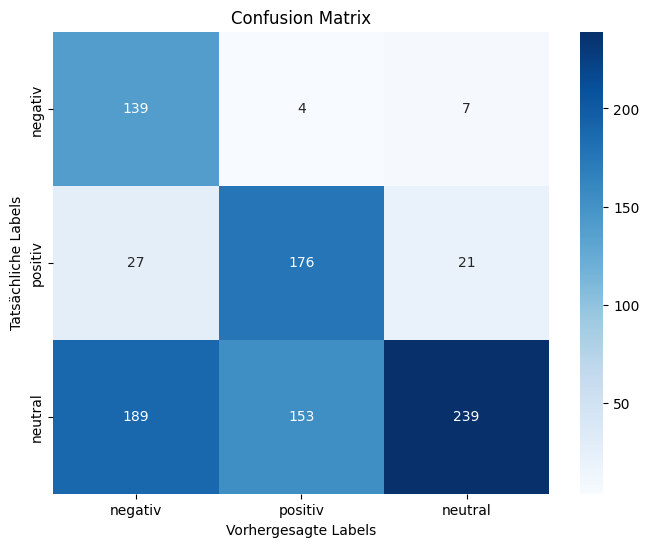

In [172]:
# Confusion Matrix berechnen (true_labels und predicted_labels sind die tatsächlichen und vorhergesagten Labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Klassenlabels definieren
class_names = ['negativ', 'positiv', 'neutral']

# Confusion Matrix als Heatmap darstellen
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Achsen beschriften
plt.xlabel('Vorhergesagte Labels')
plt.ylabel('Tatsächliche Labels')
plt.title('Confusion Matrix')

# Plot anzeigen
plt.show()